In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/Users/varunmittal/Downloads/E-commerce  cosmetic dataset.csv", encoding = "latin-1")
df.head(3)

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,type,color,size,rating,noofratings
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,Carlton London,NaN,aerosol,NaN,"Top Note: Orange Blossom, Blackberry | Heart N...",100,3.9,19
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,031"
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,072"


In [4]:
def sizeclean(point):
    if type(point)==str:
        point=point.split(" ")[0]
        point=float(point)
    return point

In [5]:
df['size']=df['size'].apply(sizeclean)

In [6]:
# Convert the 'size' column to numeric, forcing errors to NaN
df['size'] = pd.to_numeric(df['size'], errors='coerce')

In [7]:
# Fill 'No type' for records with blank type value
df['type'] = df['type'].fillna('No type')
# Group by 'category' & 'subcategory' and fill NaN values with the mean of the group
df['size_cv'] = df.groupby(['category','subcategory'])['size'].transform(lambda x: x.fillna(x.mean()))
df['price_cv'] = df.groupby(['category','subcategory'])['price'].transform(lambda x: x.fillna(x.mean()))
df.isna().sum()

product_name       0
website            0
country            0
category           0
subcategory        0
title-href         0
price            317
brand              0
ingredients     6015
form               0
type               0
color           1989
size            3166
rating          2067
noofratings      459
size_cv            0
price_cv           0
dtype: int64

In [8]:
df.shape

(12615, 17)

**Option 1: Classify brand by price across all products**

In [10]:
def classify_price(price):
    if price > 10000:
        return 'luxury brand'
    elif price < 2860:
        return 'budget'
    elif 2860 <= price <= 10000:
        return 'mid tier'
df['brand_group'] = df['price_cv'].apply(classify_price)

luxury_count = df[df['brand_group'] == 'luxury brand'].shape[0]
budget_count = df[df['brand_group'] == 'budget'].shape[0]
mid_tier_count = df[df['brand_group'] == 'mid tier'].shape[0]

print(luxury_count,mid_tier_count,budget_count,luxury_count+mid_tier_count+budget_count )
# print(df)

296 2792 9527 12615


**Option 2: Classify brand/product class by price percentile in each category**

In [11]:
# Function to classify based on percentiles
def classify_price(x):
    if x <= 0.6:
        return 'Regular'
    elif x <= 0.95:
        return 'Premium'
    else:
        return 'Super Premium'

In [12]:
# The groupby method is used to group the DataFrame by the brand column.
# The transform method along with rank(pct=True) calculates the percentile rank for each price within its brand group
df['percentile'] = df.groupby('category')['price_cv'].transform(lambda x: x.rank(pct=True))

df['product_class'] = df['percentile'].apply(classify_price)

In [14]:
# Group by brand and product_class, and count occurrences
product_class_counts = df.groupby(['brand', 'product_class']).size().reset_index(name='count')

# Find the product class with the maximum count for each brand
max_product_class = product_class_counts.loc[product_class_counts.groupby('brand')['count'].idxmax()]

# Reset index for the final DataFrame
max_product_class = max_product_class.reset_index(drop=True)
max_product_class.rename(columns={'product_class':'brand_class'}, inplace=True)
print(max_product_class.shape, df.brand.nunique())
max_product_class.head(3)

(1753, 3) 1753


,brand,brand_class,count
0,100% PURE,Premium,1
1,1000Hour,Premium,1
2,18.21 Man Made,Regular,1


In [15]:
df = df.merge(max_product_class[['brand', 'brand_class']], on = 'brand', how = 'left')
df.head()

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,color,size,rating,noofratings,size_cv,price_cv,brand_group,percentile,product_class,brand_class
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,Carlton London,NaN,aerosol,...,"Top Note: Orange Blossom, Blackberry | Heart N...",100.0,3.9,19,100.0,599.0,budget,0.257926,Regular,Regular
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,Charlene,NaN,aerosol,...,Unit count type:,30.0,4.4,"4,031",30.0,149.0,budget,0.030528,Regular,Regular
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,Charlene,NaN,aerosol,...,Unit count type:,30.0,4.4,"4,072",30.0,298.0,budget,0.120352,Regular,Regular
3,DENVER Black Code Perfume - 60 | Eau de Parfum...,Flipkart,India,body,perfume,https://www.amazon.in/DENVER-Black-Code-Perfum...,245.0,Denver,NaN,aerosol,...,Long-Lasting Scent,60.0,4.2,61,60.0,245.0,budget,0.087084,Regular,Regular
4,Denver Hamilton Perfume - 100 | Long Lasting P...,Flipkart,India,body,perfume,https://www.amazon.in/Denver-Perfume-Hamilton-...,422.0,Denver,NaN,aerosol,...,Long-Lasting Scent,100.0,4.3,342,100.0,422.0,budget,0.194912,Regular,Regular


**rating/noofratings Column Transform:**  if noofratings is blank & rating >10, then rating is noofratings. For the rest impute missing values using mean/median of the sub-category

In [16]:
df['rating'] = df['rating'].str.split(" ").str[0]
df['rating'] = df['rating'].str.replace(',', '')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
incorrect_ratings = df['rating'] > 10
df.loc[incorrect_ratings, 'noofratings'] = df.loc[incorrect_ratings, 'rating']
df.loc[incorrect_ratings, 'rating'] = 0

In [17]:
def ratingno(point):
    if point in ('Write A Review','No reviews','New to Amazon'):
        point = 0
    elif type(point)==str:
        point=point.split(" ")[0]
        point=point.replace(",","")
        point=float(point)
    return point
df['noofratings_cv']=df['noofratings'].apply(ratingno)

In [18]:
df['rating'] = df.groupby('subcategory')['rating'].transform(lambda x: x.fillna(x.mean()).mask((x == 0) | (x > 5), x.mean()))
df['rating'] = df['rating'].round(1)

In [19]:
print(df.shape)
df.isna().sum()

(12615, 22)


product_name         0
website              0
country              0
category             0
subcategory          0
title-href           0
price              317
brand                0
ingredients       6015
form                 0
type                 0
color             1989
size              3166
rating             674
noofratings        405
size_cv              0
price_cv             0
brand_group          0
percentile           0
product_class        0
brand_class          0
noofratings_cv     405
dtype: int64

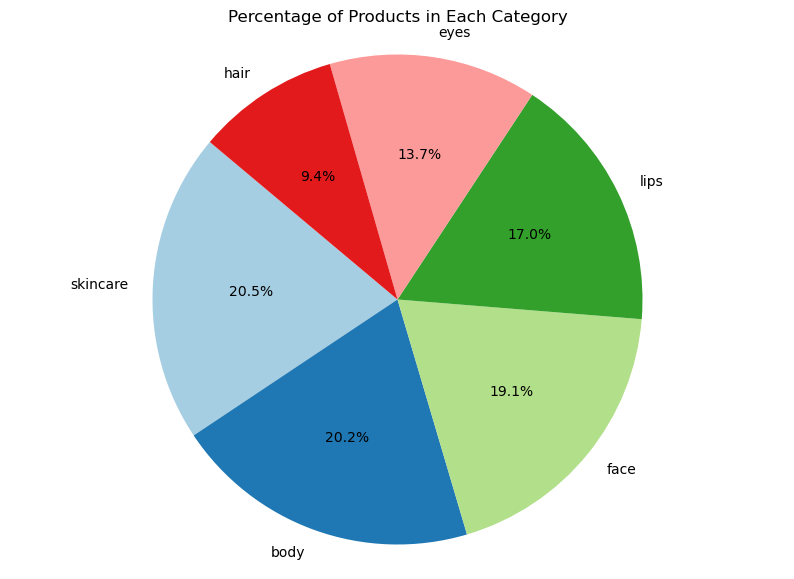

/var/folders/lr/48987hw55tq1fctvh82pxdx80000gn/T/ipykernel_30575/2071790422.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


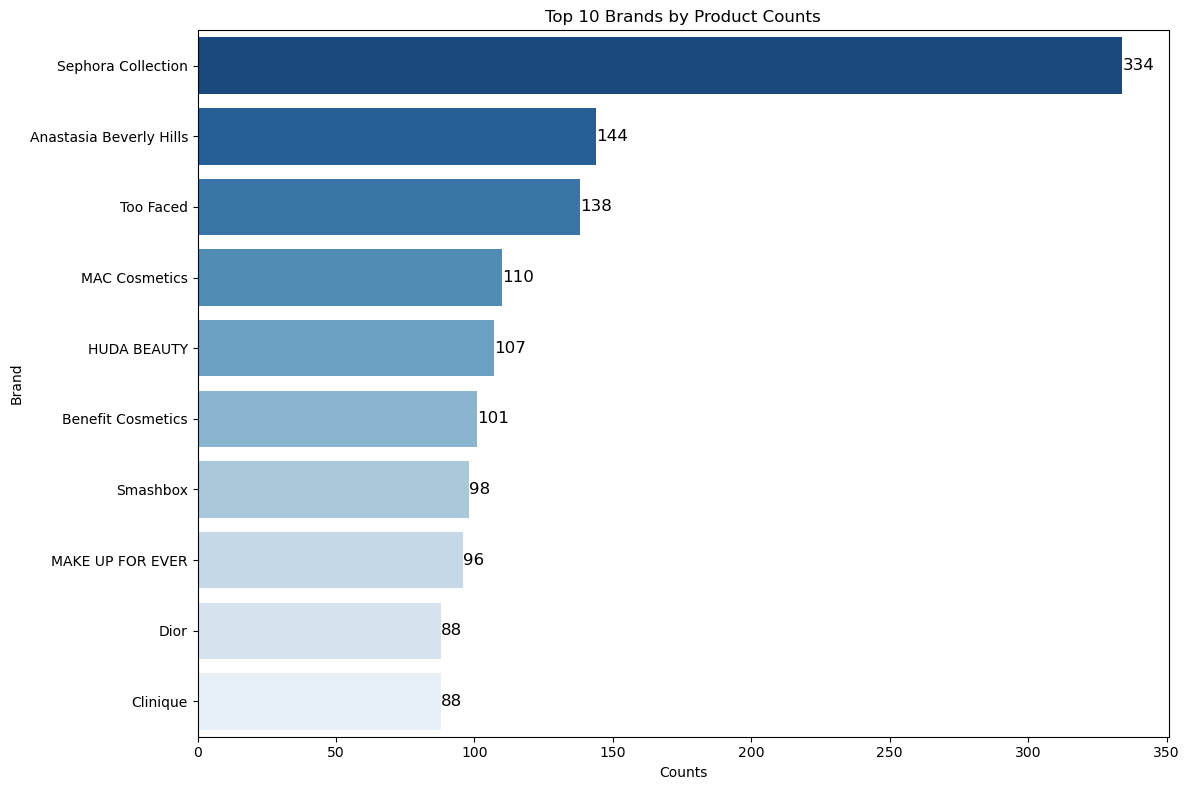

/var/folders/lr/48987hw55tq1fctvh82pxdx80000gn/T/ipykernel_30575/2071790422.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y='noofratings', palette='Set3')


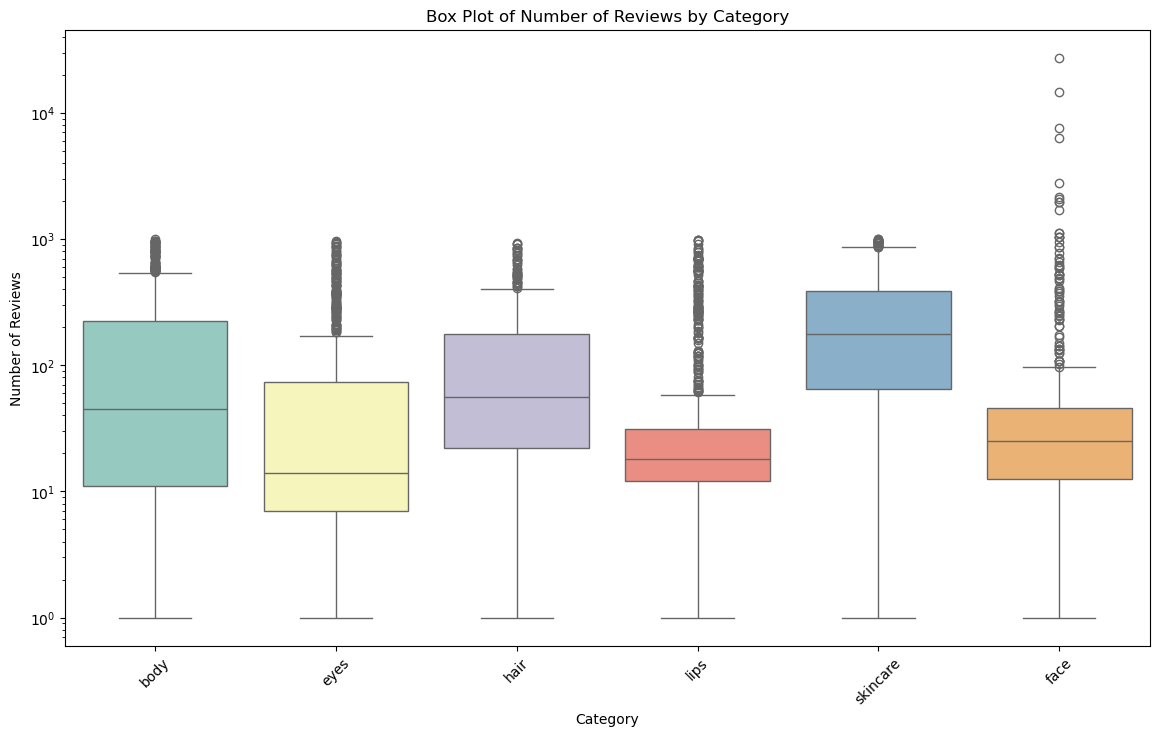

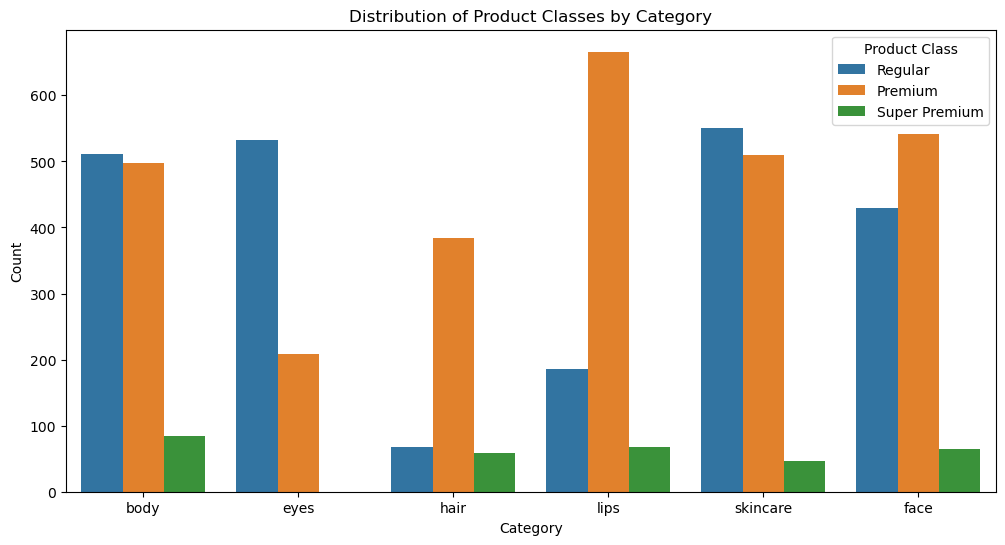

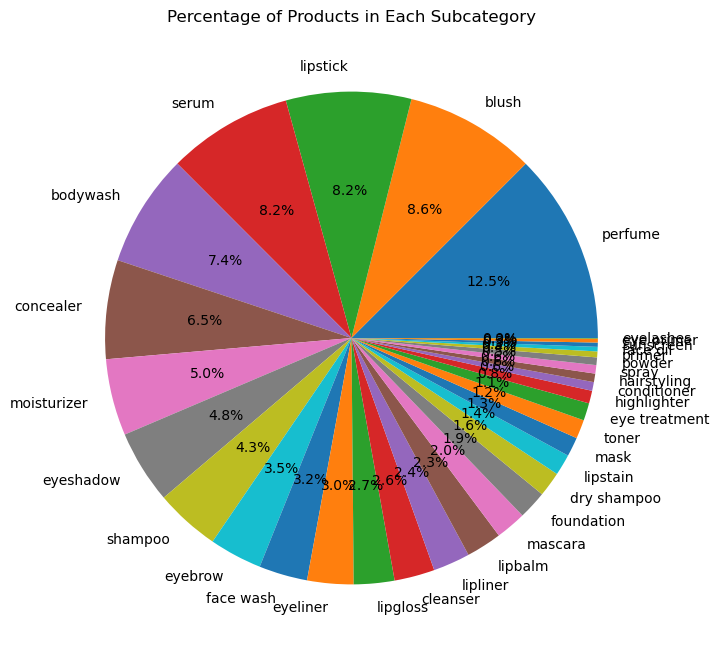

/var/folders/lr/48987hw55tq1fctvh82pxdx80000gn/T/ipykernel_30575/2071790422.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


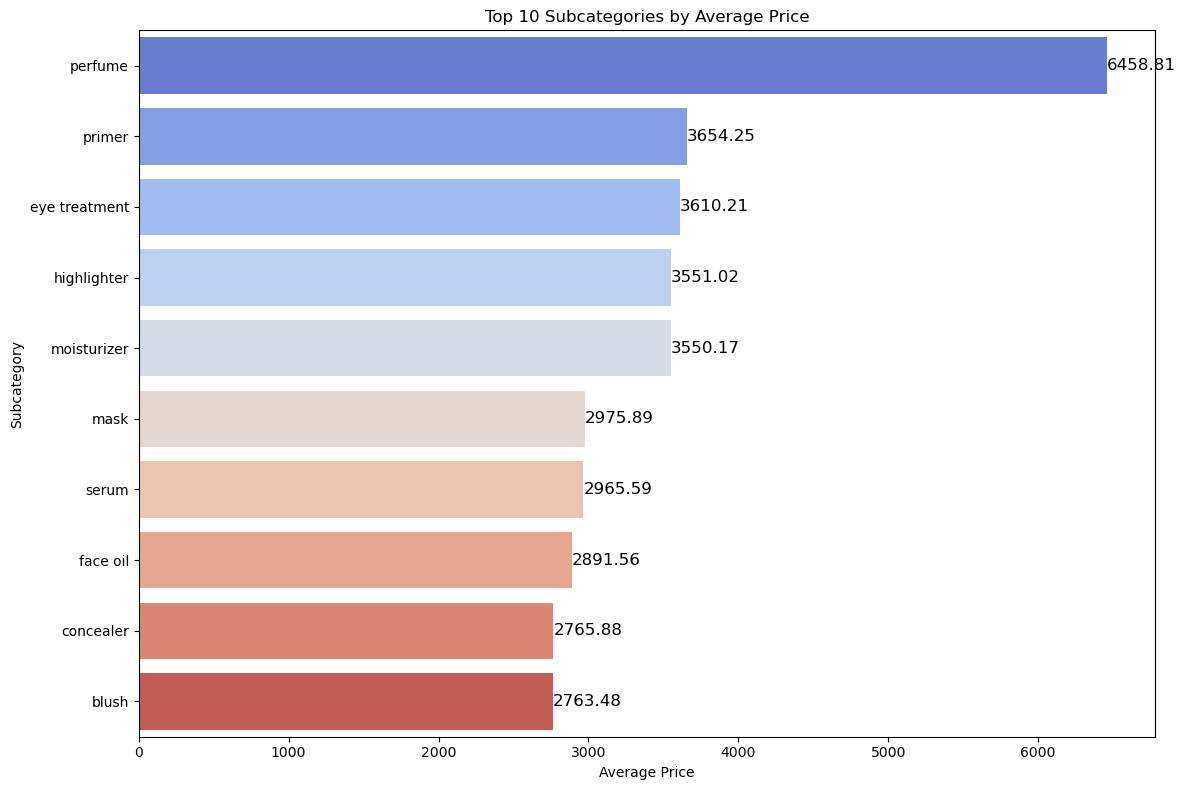

In [34]:
#Graph 1
category_counts = df['category'].value_counts()

# Calculate the percentage of products in each category
category_percentages = (category_counts / category_counts.sum()) * 100

# Plot a pie chart
plt.figure(figsize=(10, 7))
plt.pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Percentage of Products in Each Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()

#Graph 2

# Ensure 'price' and 'rating' are numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Count the number of products for each brand
brand_counts = df['brand'].value_counts().reset_index()
brand_counts.columns = ['brand', 'counts']

# Get the top 10 brands
top_10_brands = brand_counts.head(10)

# Plot the data
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    x='counts', 
    y='brand', 
    data=top_10_brands, 
    palette='Blues_r'
)

# Add count labels on top of each bar
for i, count in enumerate(top_10_brands['counts']):
    plt.text(count, i, str(count), va='center', ha='left', fontsize=12, color='black')

# Set plot title and labels
barplot.set_title('Top 10 Brands by Product Counts')
barplot.set_xlabel('Counts')
barplot.set_ylabel('Brand')

# Show the plot
plt.tight_layout()
plt.show()

# Display the top 10 brands and their counts
top_10_brands

#Graph 3
# Ensure 'number_of_reviews' is numeric
df['noofratings'] = pd.to_numeric(df['noofratings'], errors='coerce')

# Plot a box plot for number of reviews by category
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='category', y='noofratings', palette='Set3')
plt.title('Box Plot of Number of Reviews by Category')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.yscale('log')  # Log scale to better visualize the distribution
plt.show()

#Graph 4

# Example EDA: Distribution of product classes by category
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='category', hue='product_class')
plt.title('Distribution of Product Classes by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Product Class')
plt.show()

#Graph 5

# 2. Pie Chart of Subcategories
plt.figure(figsize=(8, 8))
df['subcategory'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Percentage of Products in Each Subcategory')
plt.ylabel('')
plt.show()

#Graph 6

# Ensure 'price' is numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Group by 'subcategory' and calculate the mean price
subcategory_avg_price = df.groupby('subcategory')['price'].mean().sort_values(ascending=False).head(10).reset_index()

# Plot the top 10 subcategories by average price
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    x='price', 
    y='subcategory', 
    data=subcategory_avg_price, 
    palette='coolwarm'
)

# Add price labels on top of each bar
for i, price in enumerate(subcategory_avg_price['price']):
    plt.text(price, i, f'{price:.2f}', va='center', ha='left', fontsize=12, color='black')

# Set plot title and labels
barplot.set_title('Top 10 Subcategories by Average Price')
barplot.set_xlabel('Average Price')
barplot.set_ylabel('Subcategory')

# Show the plot
plt.tight_layout()
plt.show()